In [26]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

torch.manual_seed(0)

In [3]:
## sigmoid
def sigmoid(z: torch.Tensor) -> torch.Tensor:
    z = 1/(1+torch.exp(-z))
    return z

In [4]:
class LogisticRegression(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(1, num_features), requires_grad=False)
  
    def forward(self, x):
        y = sigmoid(torch.matmul(x, torch.transpose(self.weight, 0, 1)))
        return y


# 1. The XOR problem



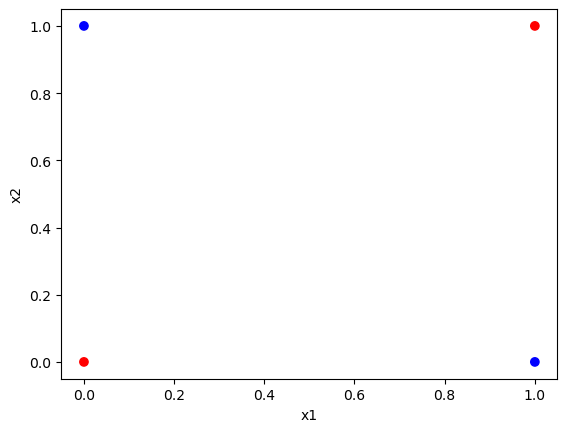

In [6]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [7]:
def sigmoid_derivative(y):
    return y*(1-y)

In [11]:
class NeuralNetwork(nn.Module):
  def __init__(self, num_inputs, num_neurons, num_outputs):
    super().__init__()
    self.hidden_layer = nn.ModuleList([LogisticRegression(num_inputs) for i in range(num_neurons)])
    self.output_layer = nn.ModuleList([LogisticRegression(num_neurons+1) for i in range(num_outputs)]) # +1 for the bias
    
    self.y_hidden = torch.ones(len(self.hidden_layer) + 1)
    self.y = torch.ones(len(self.output_layer))
    
    self.w_hidden = torch.rand(num_inputs + 1, num_neurons)
    self.w_out = torch.rand(num_neurons + 1, num_outputs)

  def forward(self, x: torch.tensor) -> torch.tensor:
    y_hidden = self.y_hidden
    
    y = self.y
    
    for i, layer in enumerate(self.hidden_layer):
        y_hidden[i] = layer(x)
        
    weights_output = []
    for i, layer in enumerate(self.output_layer):
        y[i] = layer(y_hidden)
        weights_output.append(layer.weight)
    self.w_out = torch.cat(weights_output, 0)
    
    return y
  
  def backward_pass(self, x: torch.tensor, y: torch.tensor, lr: float) -> None:

    y_hidden = self.y_hidden
    y_prediction = self.y
    
    dz = (y_prediction - y) * sigmoid_derivative(y_prediction)
    
    db = sigmoid_derivative(y_hidden) * (sum(self.w_out * dz))
    
    for i, layer in enumerate(self.output_layer):
        weight = layer.weight
        weight -= lr * dz * y_hidden
        layer.weight = nn.Parameter(weight, requires_grad = False)
    
    for i, layer in enumerate(self.hidden_layer):
        weight = layer.weight
        weight -= lr * db[i] * x
        layer.weight = nn.Parameter(weight, requires_grad = False)
    
    return

In [12]:
# test it works!!
x_test = torch.tensor([0., 0., 1.]) # last value is the bias
print(x_test.shape)
y_test = torch.tensor([0.])
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)
print(model(x_test))
print(model)
print("----------------")
for name, param in model.named_parameters():
  print(name, param)
print("-------------------")
print('\nHidden layer weight matrix:')
print(torch.stack(list(model.hidden_layer.parameters())))

torch.Size([3])
tensor([0.7767])
NeuralNetwork(
  (hidden_layer): ModuleList(
    (0): LogisticRegression()
    (1): LogisticRegression()
  )
  (output_layer): ModuleList(
    (0): LogisticRegression()
  )
)
----------------
hidden_layer.0.weight Parameter containing:
tensor([[0.5263, 0.2437, 0.5846]])
hidden_layer.1.weight Parameter containing:
tensor([[0.0332, 0.1387, 0.2422]])
output_layer.0.weight Parameter containing:
tensor([[0.8155, 0.7932, 0.2783]])
-------------------

Hidden layer weight matrix:
tensor([[[0.5263, 0.2437, 0.5846]],

        [[0.0332, 0.1387, 0.2422]]])


In [13]:
# test it works
model.backward_pass(x_test, y_test, 1)

In [14]:

def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
  #print(y_pred.shape[0])
  m = y_pred.shape[0] # number of example
  cost = torch.sum(torch.mul(-y_true, torch.log(y_pred)) - torch.mul((1-y_true),torch.log(1-y_pred)))/m
  return cost

torch.Size([4, 3])


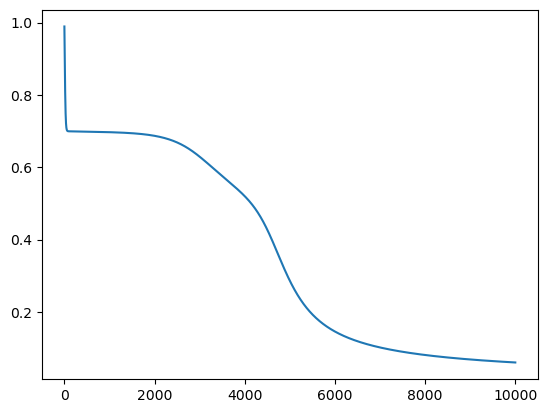

tensor([0., 1., 1., 0.]) tensor([0.0604, 0.9438, 0.9438, 0.0000])


In [15]:
x1 = torch.tensor([0., 0., 1., 1.])
x2 = torch.tensor([0., 1., 0., 1.])
bias = torch.ones_like(x1)
x = torch.stack([x1, x2, bias]).permute(1, 0)
print(x.shape)
y = torch.tensor([0., 1., 1., 0.])

lr = 0.1

iterations = 10000
model = NeuralNetwork(num_inputs=3, num_neurons=2, num_outputs=1)

errors = list()
for ep in range(iterations):
  error = 0
  for i in range(x.shape[0]):
    y_pred = model(x[i])
    error += bce(y[i], y_pred)
    model.backward_pass(x[i], y[i], lr)
  errors.append(error/x.shape[0])
plt.plot(list(range(iterations)), errors)
plt.show()

y_pred = torch.zeros_like(y)
for i in range(x.shape[1]):
  y_pred[i] = model(x[i])
print(y, y_pred)

In [16]:
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Split the data to train and test sets (make sure the same random seed is used as previously) and normalize using the method from week 4. We will use all attributes in this lab. [2 marks]

In [17]:
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']
print(names)
print(feature_names)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris.data,
    iris.target,
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
x_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).long()


['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [18]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
    X_normalized = (x-mu)/sigma
    return X_normalized

mu = torch.mean(x_train, dim=0)
sigma = torch.std(x_train, dim=0)

x_train_norm = norm_set(x_train, mu, sigma)

x_test_norm = norm_set(x_test, mu, sigma)

In [19]:
class Model(nn.Module):
    def __init__(self, input_neurons, hidden_neurons):
        super(Model,self).__init__()
        self.layer1 = nn.Linear(input_neurons, hidden_neurons)
        self.layer2 = nn.Linear(hidden_neurons, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim = 1)
        return x


In [20]:
def train(model, x_train, y_train, x_test, y_test, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  
  for i in range(1000):
    
    prediction = model(x_train)
    
    cost = loss_fn(prediction, y_train)
    
    optimiser.zero_grad()
    cost.backward()
    
    train_lst.append(cost.item())
    
    optimiser.step()
    
    model.eval()
    
    with torch.no_grad():
      test_prediction = model(x_test)
      test_cost = loss_fn(test_prediction, y_test)
      test_lst.append(test_cost)
  
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))
  
  


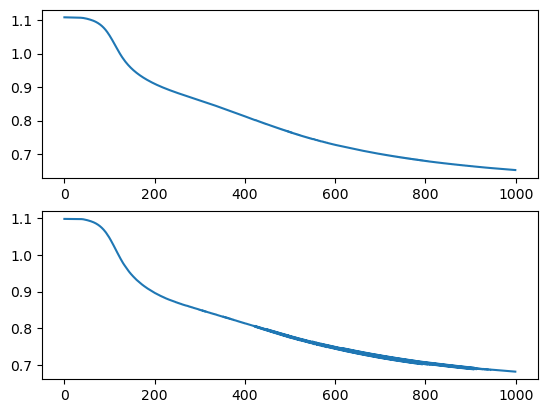

Minimum train cost: 0.6522998213768005
Minimum test cost: 0.6828988790512085


In [21]:
alpha = 0.1
no_of_hideen_neurons = 1

model = Model(x_train.shape[1], no_of_hideen_neurons)

optimizer = optim.SGD(model.parameters(), alpha)

loss_fn = nn.CrossEntropyLoss()

train(model, x_train, y_train, x_test, y_test, optimizer, alpha)

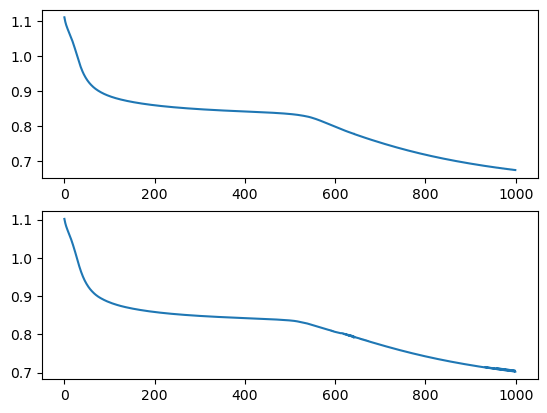

Minimum train cost: 0.6741330027580261
Minimum test cost: 0.7023594379425049


In [22]:
alpha = 0.1
no_of_hideen_neurons = 2

model = Model(x_train.shape[1], no_of_hideen_neurons)

optimizer = optim.SGD(model.parameters(), alpha)

loss_fn = nn.CrossEntropyLoss()

train(model, x_train, y_train, x_test, y_test, optimizer, alpha)

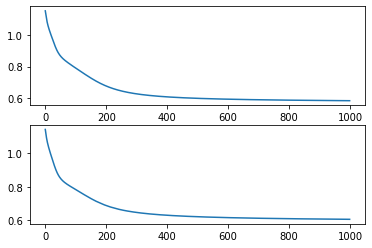

Minimum train cost: 0.5853500962257385
Minimum test cost: 0.6055614948272705


In [18]:
alpha = 0.1
no_of_hideen_neurons = 4

model = Model(x_train.shape[1], no_of_hideen_neurons)

optimizer = optim.SGD(model.parameters(), alpha)

loss_fn = nn.CrossEntropyLoss()

train(model, x_train, y_train, x_test, y_test, optimizer, alpha)

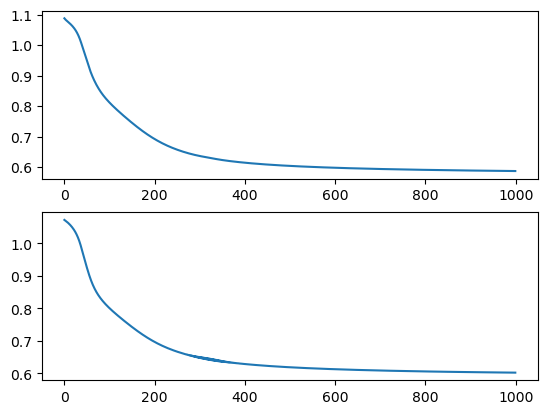

Minimum train cost: 0.586814284324646
Minimum test cost: 0.6020529866218567


In [23]:
alpha = 0.1
no_of_hideen_neurons = 8

model = Model(x_train.shape[1], no_of_hideen_neurons)

optimizer = optim.SGD(model.parameters(), alpha)

loss_fn = nn.CrossEntropyLoss()

train(model, x_train, y_train, x_test, y_test, optimizer, alpha)

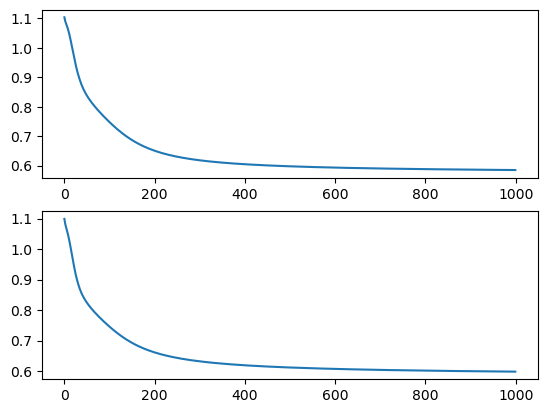

Minimum train cost: 0.5848101377487183
Minimum test cost: 0.5978454351425171


In [24]:
alpha = 0.1
no_of_hideen_neurons = 16

model = Model(x_train.shape[1], no_of_hideen_neurons)

optimizer = optim.SGD(model.parameters(), alpha)

loss_fn = nn.CrossEntropyLoss()

train(model, x_train, y_train, x_test, y_test, optimizer, alpha)

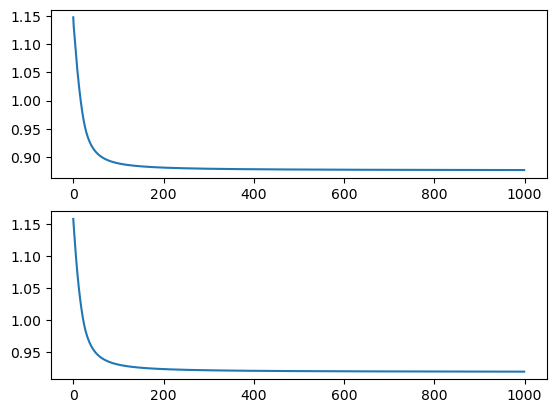

Minimum train cost: 0.8771976232528687
Minimum test cost: 0.9187323451042175


In [25]:
alpha = 0.1
no_of_hideen_neurons = 32

model = Model(x_train.shape[1], no_of_hideen_neurons)

optimizer = optim.SGD(model.parameters(), alpha)

loss_fn = nn.CrossEntropyLoss()

train(model, x_train, y_train, x_test, y_test, optimizer, alpha)